# **Task 8-1. CVAE**

**Task 8-1:** Study implementation examples CVAE
(https://www.tensorflow.org/tutorials/generative/cvae). Choose another dataset (not fashion MNIST,
but some other domain specific dataset) and make corresponding changes in the code to fit the dataset.
Present generated images.

In [ ]:
!pip install tensorflow-probability

# to generate gifs
!pip install imageio
!pip install git+https://github.com/tensorflow/docs

  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-7ruurjo4
  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/docs /tmp/pip-req-build-7ruurjo4
  Resolved https://github.com/tensorflow/docs to commit 9efadf0a84eae76e347787e344626650ea4ed85b
  Preparing metadata (setup.py) ... done
  Created wheel for tensorflow-docs: filename=tensorflow_docs-2024.3.27.3713-py3-none-any.whl size=182447 sha256=ac3371ea2053cb55dfe5fb3bfa1db85ce8ecb1045039729faf06089b4b38e576
  Stored in directory: /tmp/pip-ephem-wheel-cache-3254gu2x/wheels/86/0f/1e/3b62293c8ffd0fd5a49508e6871cdb7554abe9c62afd35ec53
Successfully built tensorflow-docs


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import cifar100

# Load the CIFAR-100 dataset
(_, _), (x_test, y_test) = cifar100.load_data()

169001437/169001437 [==============================] - 2s 0us/step


In [ ]:
from IPython import display

import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
import tensorflow_probability as tfp
import time

In [ ]:
(train_images, _), (test_images, _) = tf.keras.datasets.fashion_mnist.load_data()

4422102/4422102 [==============================] - 0s 0us/step


In [ ]:
(train_images, _), (test_images, _) = tf.keras.datasets.mnist.load_data()

11490434/11490434 [==============================] - 0s 0us/step


In [ ]:
def preprocess_images(images):
  images = images.reshape((images.shape[0], 28, 28, 1)) / 255.
  return np.where(images > .5, 1.0, 0.0).astype('float32')

train_images = preprocess_images(train_images)
test_images = preprocess_images(test_images)

In [ ]:
train_size = 60000
batch_size = 32
test_size = 10000

In [ ]:
train_dataset = (tf.data.Dataset.from_tensor_slices(train_images)
                 .shuffle(train_size).batch(batch_size))
test_dataset = (tf.data.Dataset.from_tensor_slices(test_images)
                .shuffle(test_size).batch(batch_size))

In [ ]:
class CVAE(tf.keras.Model):
  """Convolutional variational autoencoder."""

  def __init__(self, latent_dim):
    super(CVAE, self).__init__()
    self.latent_dim = latent_dim
    self.encoder = tf.keras.Sequential(
        [
            tf.keras.layers.InputLayer(input_shape=(28, 28, 1)),
            tf.keras.layers.Conv2D(
                filters=32, kernel_size=3, strides=(2, 2), activation='relu'),
            tf.keras.layers.Conv2D(
                filters=64, kernel_size=3, strides=(2, 2), activation='relu'),
            tf.keras.layers.Flatten(),
            # No activation
            tf.keras.layers.Dense(latent_dim + latent_dim),
        ]
    )

    self.decoder = tf.keras.Sequential(
        [
            tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
            tf.keras.layers.Dense(units=7*7*32, activation=tf.nn.relu),
            tf.keras.layers.Reshape(target_shape=(7, 7, 32)),
            tf.keras.layers.Conv2DTranspose(
                filters=64, kernel_size=3, strides=2, padding='same',
                activation='relu'),
            tf.keras.layers.Conv2DTranspose(
                filters=32, kernel_size=3, strides=2, padding='same',
                activation='relu'),
            # No activation
            tf.keras.layers.Conv2DTranspose(
                filters=1, kernel_size=3, strides=1, padding='same'),
        ]
    )

  @tf.function
  def sample(self, eps=None):
    if eps is None:
      eps = tf.random.normal(shape=(100, self.latent_dim))
    return self.decode(eps, apply_sigmoid=True)

  def encode(self, x):
    mean, logvar = tf.split(self.encoder(x), num_or_size_splits=2, axis=1)
    return mean, logvar

  def reparameterize(self, mean, logvar):
    eps = tf.random.normal(shape=mean.shape)
    return eps * tf.exp(logvar * .5) + mean

  def decode(self, z, apply_sigmoid=False):
    logits = self.decoder(z)
    if apply_sigmoid:
      probs = tf.sigmoid(logits)
      return probs
    return logits

In [ ]:
optimizer = tf.keras.optimizers.Adam(1e-4)


def log_normal_pdf(sample, mean, logvar, raxis=1):
  log2pi = tf.math.log(2. * np.pi)
  return tf.reduce_sum(
      -.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi),
      axis=raxis)


def compute_loss(model, x):
  mean, logvar = model.encode(x)
  z = model.reparameterize(mean, logvar)
  x_logit = model.decode(z)
  cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)
  logpx_z = -tf.reduce_sum(cross_ent, axis=[1, 2, 3])
  logpz = log_normal_pdf(z, 0., 0.)
  logqz_x = log_normal_pdf(z, mean, logvar)
  return -tf.reduce_mean(logpx_z + logpz - logqz_x)


@tf.function
def train_step(model, x, optimizer):
  """Executes one training step and returns the loss.

  This function computes the loss and gradients, and uses the latter to
  update the model's parameters.
  """
  with tf.GradientTape() as tape:
    loss = compute_loss(model, x)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))

In [ ]:
epochs = 10
# set the dimensionality of the latent space to a plane for visualization later
latent_dim = 2
num_examples_to_generate = 16

# keeping the random vector constant for generation (prediction) so
# it will be easier to see the improvement.
random_vector_for_generation = tf.random.normal(
    shape=[num_examples_to_generate, latent_dim])
model = CVAE(latent_dim)

In [ ]:
def generate_and_save_images(model, epoch, test_sample):
  mean, logvar = model.encode(test_sample)
  z = model.reparameterize(mean, logvar)
  predictions = model.sample(z)
  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
    plt.subplot(4, 4, i + 1)
    plt.imshow(predictions[i, :, :, 0], cmap='gray')
    plt.axis('off')

  # tight_layout minimizes the overlap between 2 sub-plots
  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

In [ ]:
# Pick a sample of the test set for generating output images
assert batch_size >= num_examples_to_generate
for test_batch in test_dataset.take(1):
  test_sample = test_batch[0:num_examples_to_generate, :, :, :]

Epoch: 10, Test set ELBO: -193.93521118164062, time elapse for current epoch: 74.11086702346802


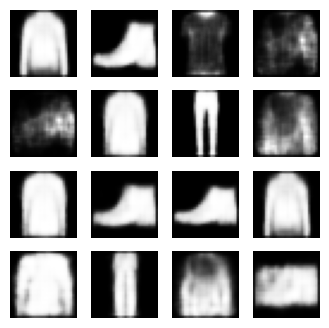

In [ ]:
generate_and_save_images(model, 0, test_sample)

for epoch in range(1, epochs + 1):
  start_time = time.time()
  for train_x in train_dataset:
    train_step(model, train_x, optimizer)
  end_time = time.time()

  loss = tf.keras.metrics.Mean()
  for test_x in test_dataset:
    loss(compute_loss(model, test_x))
  elbo = -loss.result()
  display.clear_output(wait=False)
  print('Epoch: {}, Test set ELBO: {}, time elapse for current epoch: {}'
        .format(epoch, elbo, end_time - start_time))
  generate_and_save_images(model, epoch, test_sample)

In [ ]:
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

In [ ]:
anim_file = 'cvae.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

<ipython-input-16-a6dbd3b71488>:7: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)
<ipython-input-16-a6dbd3b71488>:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)



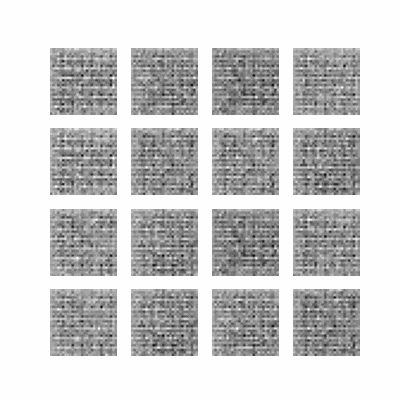

In [ ]:
import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file)

In [ ]:
def plot_latent_images(model, n, digit_size=28):
  """Plots n x n digit images decoded from the latent space."""

  norm = tfp.distributions.Normal(0, 1)
  grid_x = norm.quantile(np.linspace(0.05, 0.95, n))
  grid_y = norm.quantile(np.linspace(0.05, 0.95, n))
  image_width = digit_size*n
  image_height = image_width
  image = np.zeros((image_height, image_width))

  for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
      z = np.array([[xi, yi]])
      x_decoded = model.sample(z)
      digit = tf.reshape(x_decoded[0], (digit_size, digit_size))
      image[i * digit_size: (i + 1) * digit_size,
            j * digit_size: (j + 1) * digit_size] = digit.numpy()

  plt.figure(figsize=(10, 10))
  plt.imshow(image, cmap='Greys_r')
  plt.axis('Off')
  plt.show()

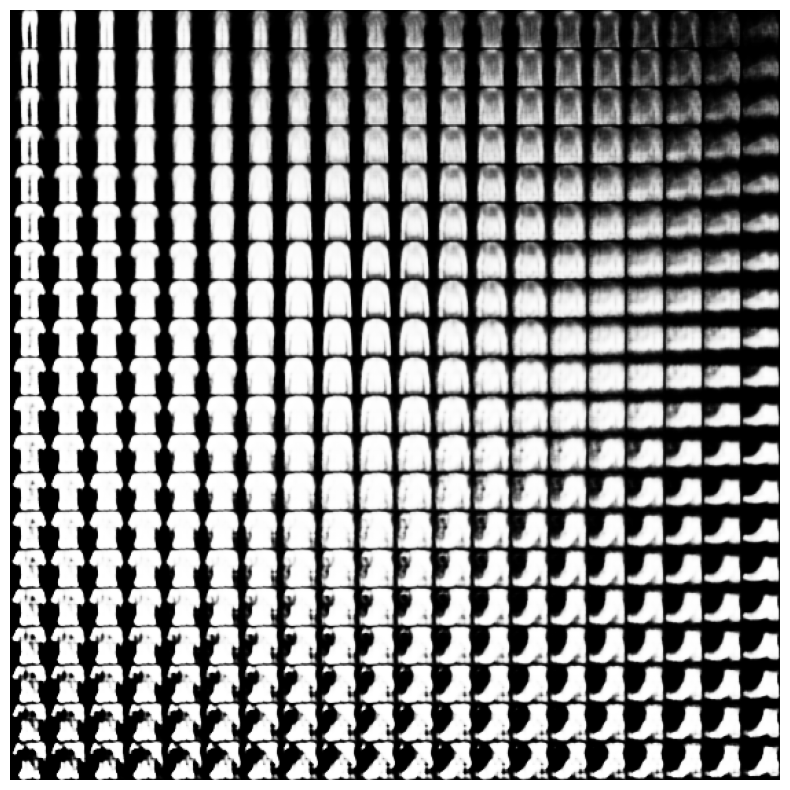

In [ ]:
plot_latent_images(model, 20)

# **Task 8-2. DCGAN**

**Task 8-2:** Study implementation example of DCGAN
(https://www.tensorflow.org/tutorials/generative/dcgan). Play with the code and convert Convolutional
GAN into MLP (fully connected layers based) GAN. Please, do not search for separate existing
implementation, but modify the initial DCGAN code. Run both codes and compare results of
generated images. Choose another dataset (not fashion MNIST, but some other domain specific
dataset)(could be the same dataset as in the Task 8-1) and make corresponding changes in the code to
fit the dataset. Present generated images.

In [1]:
import tensorflow as tf

In [2]:
# To generate GIFs
!pip install imageio
!pip install git+https://github.com/tensorflow/docs

  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-gu0abuvg
  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/docs /tmp/pip-req-build-gu0abuvg
  Resolved https://github.com/tensorflow/docs to commit 9efadf0a84eae76e347787e344626650ea4ed85b
  Preparing metadata (setup.py) ... done
  Created wheel for tensorflow-docs: filename=tensorflow_docs-2024.3.27.3713-py3-none-any.whl size=182447 sha256=b752adee7794c10064081ed284314d884ff795f6874b83c738b7af1b98e1c07d
  Stored in directory: /tmp/pip-ephem-wheel-cache-_cvyi6kf/wheels/86/0f/1e/3b62293c8ffd0fd5a49508e6871cdb7554abe9c62afd35ec53
Successfully built tensorflow-docs


In [3]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time

from IPython import display

In [4]:
(train_images, train_labels), (_, _) = tf.keras.datasets.fashion_mnist.load_data()

4422102/4422102 [==============================] - 0s 0us/step


In [5]:
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5  # Normalize the images to [-1, 1]

In [6]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256

In [7]:
# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [8]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256)  # Note: None is the batch size

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model

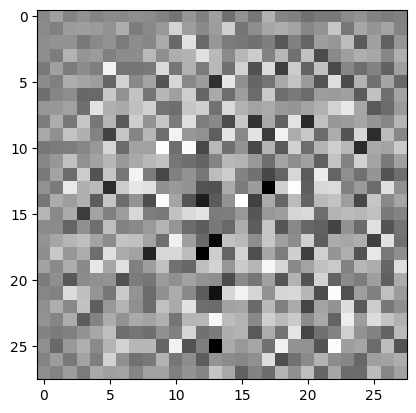

In [9]:
generator = make_generator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

In [10]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [11]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[-0.00110961]], shape=(1, 1), dtype=float32)


In [12]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [13]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [14]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [15]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [16]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [17]:
EPOCHS = 25
noise_dim = 100
num_examples_to_generate = 16

# You will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [18]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [19]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    # Produce images for the GIF as you go
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)

In [20]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

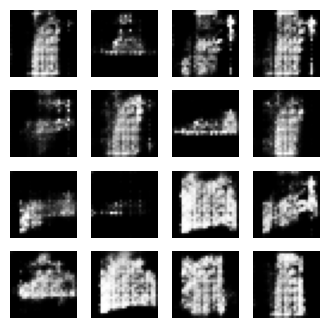

In [21]:
train(train_dataset, EPOCHS)

In [ ]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [ ]:
# Display a single image using the epoch number
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

In [ ]:
display_image(EPOCHS)

In [ ]:
anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

In [ ]:
import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file)

# **Task 8-3. Stable Diffusion**

**Task 8-3:** Study implementation example of Stable Diffusion (High-performance image generation)
(https://www.tensorflow.org/tutorials/generative/generate_images_with_stable_diffusion). Play with
your own prompts and present the results on the slides. Also, play with other image/audio/video
generation services (use the links from the lecture materials with respect to the Generative AI services,
or some other you find) and present your findings to others during the task delivery/presentation.

In [ ]:
#!pip install tensorflow keras_cv --upgrade --quiet

!pip install -q --upgrade keras-cv
!pip install -q --upgrade keras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 613.1/613.1 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 11.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 11.0 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.15.0 requires keras<2.16,>=2.15.0, but you have keras 3.2.1 which is incompatible.


In [ ]:
import time
#import tensorflow.keras
import keras_cv
from tensorflow import keras
import matplotlib.pyplot as plt

In [ ]:
model = keras_cv.models.StableDiffusion(img_width=512, img_height=512)

By using this model checkpoint, you acknowledge that its usage is subject to the terms of the CreativeML Open RAIL-M license at https://raw.githubusercontent.com/CompVis/stable-diffusion/main/LICENSE


1356917/1356917 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
492466864/492466864 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step
3439090152/3439090152 ━━━━━━━━━━━━━━━━━━━━ 40s 0us/step
50/50 ━━━━━━━━━━━━━━━━━━━━ 6179s 120s/step
198180272/198180272 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


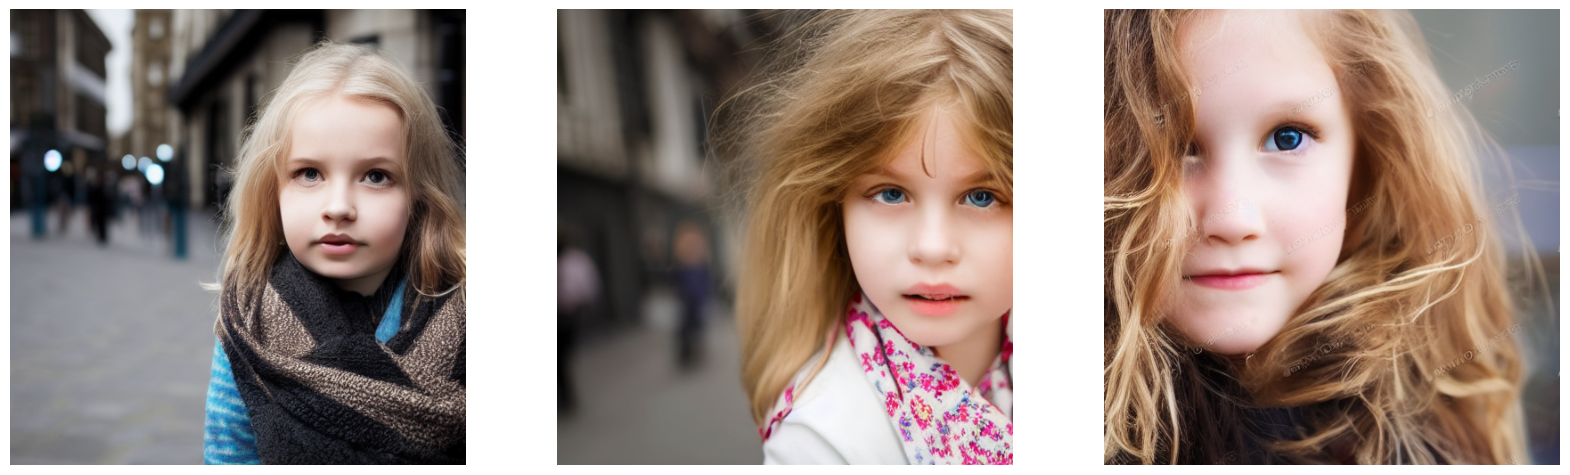

In [ ]:
images = model.text_to_image("young girl with wavy blond hair and brown eyes in London", batch_size=3)


def plot_images(images):
    plt.figure(figsize=(20, 20))
    for i in range(len(images)):
        ax = plt.subplot(1, len(images), i + 1)
        plt.imshow(images[i])
        plt.axis("off")


plot_images(images)

In [ ]:
images = model.text_to_image(
    "white gothic estate in Scotland, relistic photographic style, "
    "Hogwarts halls, cartoonish 2D style,nmystery, dogital painting, adventure "
    "concept art, starboy character concepts, digital painting, mystery, adventure",
    batch_size=3,
)
plot_images(images)

1356917/1356917 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
492466864/492466864 ━━━━━━━━━━━━━━━━━━━━ 7s 0us/step
3439090152/3439090152 ━━━━━━━━━━━━━━━━━━━━ 74s 0us/step
50/50 ━━━━━━━━━━━━━━━━━━━━ 5417s 105s/step
198180272/198180272 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


NameError: name 'plot_images' is not defined

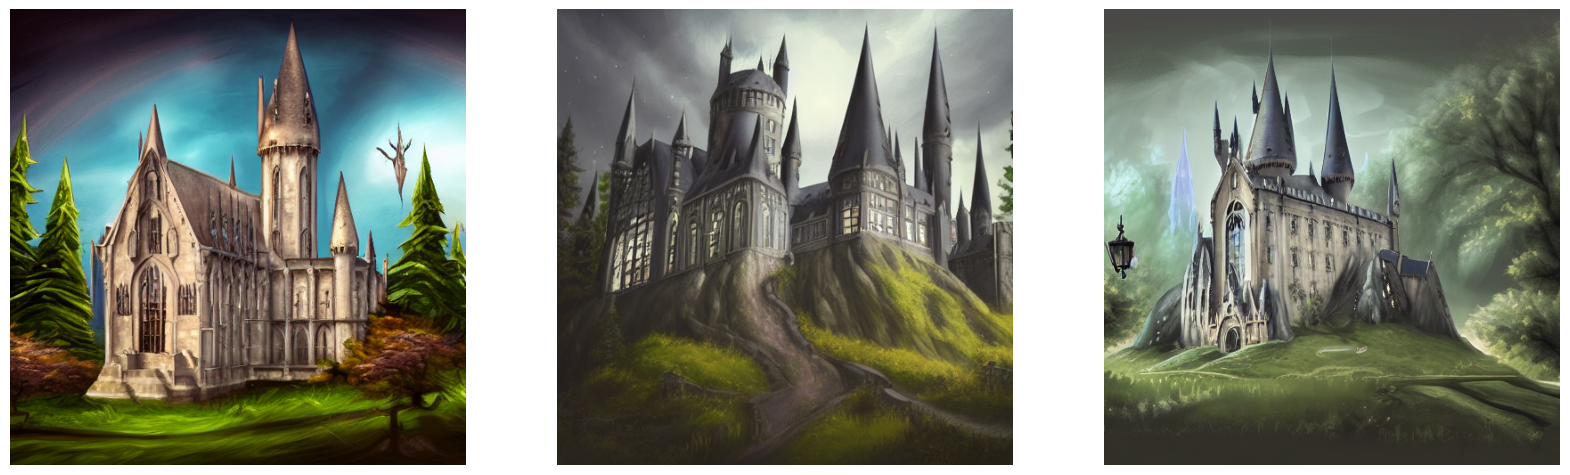

In [ ]:
plot_images(images)

In [ ]:
def plot_images(images):
    plt.figure(figsize=(20, 20))
    for i in range(len(images)):
        ax = plt.subplot(1, len(images), i + 1)
        plt.imshow(images[i])
        plt.axis("off")

# **EXTRA Task 8-4**

**Task 8-4 (extra):** Choose one of the following topics, study paper(s) and corresponding
implementations (also use the relevant links mentioned on the lecture slides as well as any other
materials you find on the web). Study initial research paper, corresponding implementation and
highlight the important aspects of the idea and implementation (model architecture, dataset specifics,
training process with loss function, etc.). Prepare own tutorial on the chosen topic and be ready to
present it to other students. If it is feasible, try to use different dataset.